In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

In [3]:
#mirrored_strategy = tf.distribute.MirroredStrategy(["/GPU:0","/GPU:1", "/GPU:2"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())

In [4]:
n_kernel=100
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 128
strides = 1
input_size = 100
lr=0.001

In [5]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [6]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133, 16, 1, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\rotatedInterpolation_pow2\\n_grid128\\velocityMagnitudeField"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "alpha"+ str(int(alpha[j])) + "_velocityMagnitudeInterpolated.csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [12]:
image_np = image_df.iloc[:, :].values

In [13]:
image = image_np.reshape((133, 16, n_grid+1, n_grid+1))

In [14]:
image = 1-image/100

In [15]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [16]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [17]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [18]:
y = y.reshape((133, 16, 2, 1))

In [19]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [20]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [21]:
geometry.shape

(2128, 1)

In [22]:
geometry = geometry.reshape((133, 16, 1))

In [23]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [24]:
#x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
#x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
#aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
#aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
#geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
#geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
#y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
#y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [25]:
x_train.shape

(126, 16, 129, 129)

In [26]:
y_train.shape

(126, 16, 2, 1)

In [27]:
tf.keras.backend.set_image_data_format('channels_first')

In [29]:
#with mirrored_strategy.scope():
input_image = tf.keras.Input(shape=(alpha.shape[0], n_grid+1, n_grid+1))
#reshape0 = tf.keras.layers.Reshape(())

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)

reshape1 = tf.keras.layers.Flatten()(x_)

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=32, activation='linear', name='outputLayer')(x_)
output_image = tf.keras.layers.Reshape((16, 2, 1))(output_data)
# AeroCNN-II
model = tf.keras.Model(input_image, output_image)

In [30]:
#with mirrored_strategy.scope():
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 129, 129)]    0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 200, 129, 129)     80200     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 200, 64, 64)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 819200)            0         
                                                                 
 firstHiddenLayer (Dense)    (None, 200)               163840200 
                                                                 
 secondHiddenLayer (Dense)   (None, 100)               20100     
                                                             

In [31]:
#with mirrored_strategy.scope():
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [32]:
#with mirrored_strategy.scope():
start = datetime.datetime.now()
history = model.fit(x_train, y_train, epochs=5000, shuffle=True,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)])
end = datetime.datetime.now()

Epoch 1/5000
4/4 [==============================] - 5s 106ms/step - loss: 348.8527 - rmse: 18.6776
Epoch 2/5000
4/4 [==============================] - 0s 44ms/step - loss: 0.4300 - rmse: 0.6557
Epoch 3/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.1886 - rmse: 0.4343
Epoch 4/5000
4/4 [==============================] - 0s 44ms/step - loss: 0.1447 - rmse: 0.3804
Epoch 5/5000
4/4 [==============================] - 0s 44ms/step - loss: 0.1338 - rmse: 0.3658
Epoch 6/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.0922 - rmse: 0.3036
Epoch 7/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.0749 - rmse: 0.2736
Epoch 8/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.0563 - rmse: 0.2373
Epoch 9/5000
4/4 [==============================] - 0s 44ms/step - loss: 0.0482 - rmse: 0.2196
Epoch 10/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.0346 - rmse: 0.1861
Epoch 11/5000
4/4 [==========================

4/4 [==============================] - 0s 43ms/step - loss: 0.0262 - rmse: 0.1618
Epoch 87/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.0231 - rmse: 0.1521
Epoch 88/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.0235 - rmse: 0.1533
Epoch 89/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.0216 - rmse: 0.1468
Epoch 90/5000
4/4 [==============================] - 0s 44ms/step - loss: 0.0202 - rmse: 0.1421
Epoch 91/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.0203 - rmse: 0.1425
Epoch 92/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.0204 - rmse: 0.1430
Epoch 93/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.0201 - rmse: 0.1417
Epoch 94/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.0198 - rmse: 0.1407
Epoch 95/5000
4/4 [==============================] - 0s 43ms/step - loss: 0.0202 - rmse: 0.1419
Epoch 96/5000
4/4 [==============================] - 0

In [33]:
time = end - start
print("Training time:", time)

Training time: 0:00:26.577451


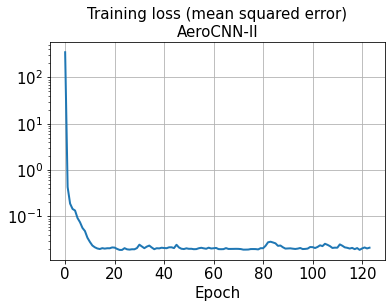

In [34]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

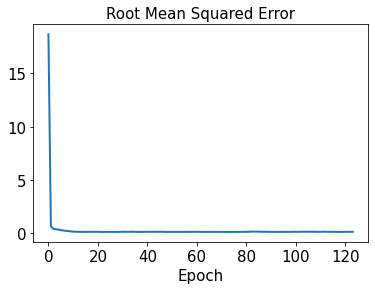

In [35]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

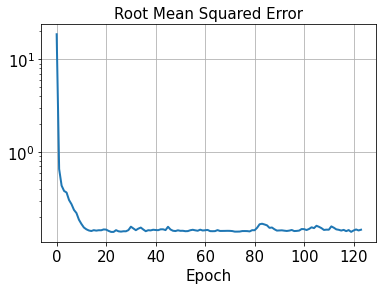

In [36]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [37]:
#with mirrored_strategy.scope():
test_results = model.evaluate(x_train)

4/4 [==============================] - 0s 4ms/step - loss: 2.3556e-06 - rmse: 0.0000e+00


In [38]:
#with mirrored_strategy.scope():
decoded_train = model.predict(x_train)

4/4 [==============================] - 0s 12ms/step


In [39]:
#with mirrored_strategy.scope():
decoded_test = model.predict(x_test)

1/1 [==============================] - 0s 58ms/step


In [40]:
error_train_abs = np.abs(decoded_train - y_train)

In [41]:
error_test_abs = np.abs(decoded_test - y_test)

In [42]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [43]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [44]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [45]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [46]:
os.chdir("D:\\TrainedModels\\20221024")
model.save('AeroCNN-II_ClCd_nGrid128_200kernel_2by2MaxPooling_1CNNlayer_testSize0.05.h5',
           overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.2622289919858315


In [48]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.2529759625444212


In [49]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.3271538108290437


In [50]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.2670530920317993


In [51]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.22921974766933334


In [52]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.13938705305191776


In [53]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.3007173985098225, 0.2558200230740699, 0.18686051322561606, 0.2592188717589809, 0.28024493870918404, 0.17980155809019094, 0.42844095470143967, 0.20979509116999856, 0.2264990988483088, 0.2896437184617227, 0.2783665891293934, 0.22139035982625271, 0.40597307831372503, 0.29216139986886536, 0.2412373054735502, 0.22685689288546784, 0.3466890116738136, 0.5125746697265318, 0.2019001618009896, 0.3853340669392191, 0.1993858459086073, 0.14908935133728218, 0.2770139567616965, 0.22520363825817685, 0.32378807872604587, 0.21197950844099905, 0.20408182942000008, 0.18574685866095828, 0.32926379607659295, 0.1289037635630946, 0.23906788725964193, 0.16356408556399188, 0.2384569894430827, 0.2713112972419268, 0.13588568223392675, 0.27459558856464666, 0.22061643659977853, 0.20865855435372907, 0.1630380107928571, 0.16022577207157865, 0.18510486641105112, 0.2794450245969429, 0.4258793239242763, 0.3227768842931269, 0.18497891525810678, 0.16615105846480138, 0.28630889173079205, 0.24902889926859326, 0.308425465

In [54]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.3424009466102531, 0.21045182345225624, 0.24961558323311595, 0.37603664618984745, 0.16285755451029787, 0.1647986001815666, 0.2822371586871335]


In [55]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.2347756347261572, 0.10976096442815021, 0.3117918377148785, 0.18085045471535954, 0.392379026482778, 0.14843332826944083, 4.411016959492075, 0.17249488338984914, 0.6972846639198996, 0.2775731379801167, 0.0765184051692414, 0.1664662379620051, 0.07512265340886008, 0.1657031246270497, 0.191371788231148, 0.6967548463612232, 0.3338844229704999, 5.411121114966798, 0.19145321673446453, 0.08621369786737025, 0.38745739493919973, 0.23127824635449315, 0.10463071366169487, 0.34569487575061963, 0.11385666611655888, 0.35049571365093635, 0.2833070243884877, 0.3087634743029712, 0.11464369143768305, 0.09508364076529466, 0.3240866426856688, 0.15749220754216098, 0.14058413674466075, 0.09867692988499586, 0.1517321868831806, 0.3153636364545557, 0.5548030588608178, 0.1551942301941237, 0.17422483044832576, 0.17889686889382683, 0.33189211316712103, 0.3360434049603676, 0.12849383510136567, 0.11974520304681645, 0.2770869841794727, 0.5668059819156857, 0.3067170521450924, 0.2718818289516728, 0.06245115896314257,

In [56]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.16367449898006037, 0.11627311414560162, 0.08742165697481842, 0.07652539412528814, 0.2317857953554633, 0.07288263537579556, 6.127330661756013, 0.04503209653874276, 0.8660445434736702, 0.24566938025771226, 0.3077315259517474, 0.052273671684433094, 0.12861419958495987, 0.19536304635265808, 0.0504696344827415, 0.4713980946128867, 0.29661790475085364, 4.748624100683829, 0.05914764940122307, 0.10031197200919104, 0.3251182135705444, 0.16124914155279402, 0.3313060472005696, 0.28235048567207743, 0.11517923528282129, 0.12182555985922235, 0.2549789940448782, 0.22639054782877152, 0.03938287113299233, 0.07633601686629832, 0.15689554478734202, 0.04567926641752301, 0.40890576009249424, 0.31901958603516245, 0.07449888284302619, 0.21825654978064504, 0.49874870578354347, 0.044610479172203614, 0.04515896236251409, 0.051815994363631136, 0.2500241901223724, 0.2874827848817458, 0.11717554829523417, 0.06681695452373938, 0.24536215861263028, 0.0630672505980361, 0.18185835603100092, 0.18624088056778387, 0.2

In [57]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

0.49874870578354347

In [58]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.2585879746892039, 0.17631446705074094, 0.3124866691317586, 0.24058722260030488, 0.20555555716704524, 0.3881785734896769, 0.06941081903575863]


In [59]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.21176897428976107, 0.04333548911912874, 0.10173820853651558, 0.01669730047051368, 0.05592116302374306, 0.22089593239013233, 0.23666504644790942]


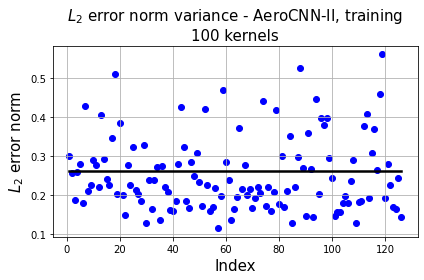

In [60]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, training\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

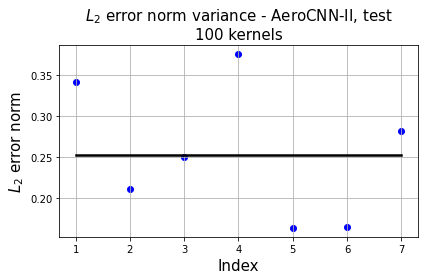

In [61]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, test\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

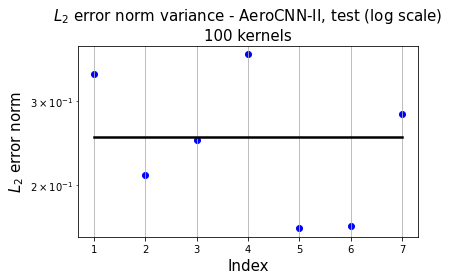

In [62]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test (log scale)\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

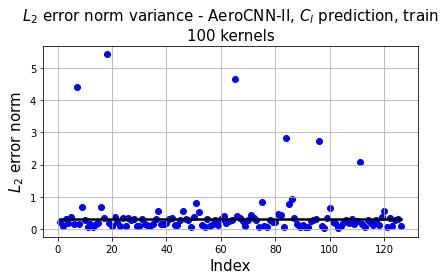

In [63]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train\n100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

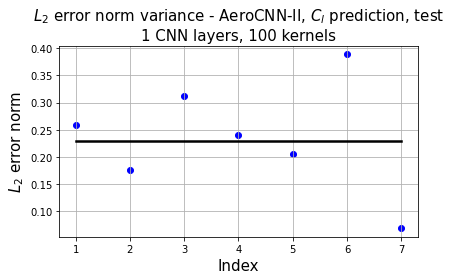

In [64]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

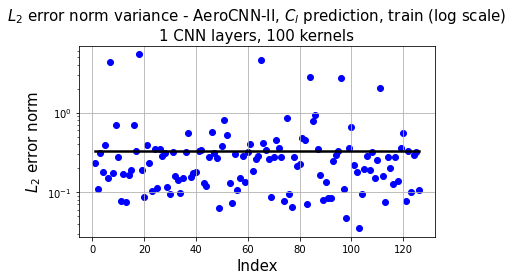

In [65]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train (log scale)\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

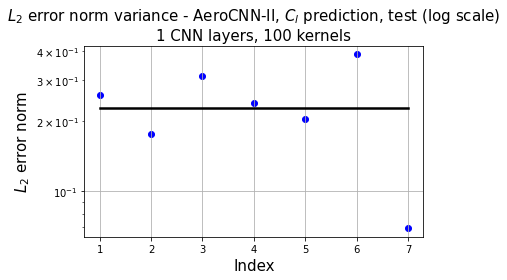

In [66]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test (log scale)\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

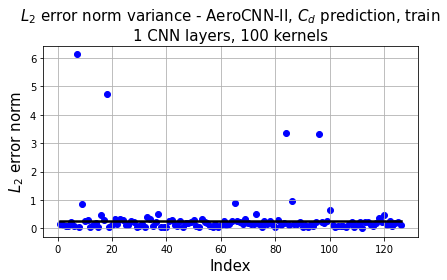

In [67]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

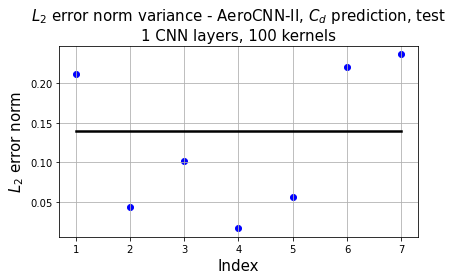

In [68]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

ValueError: x and y can be no greater than 2D, but have shapes (126,) and (126, 2, 1)

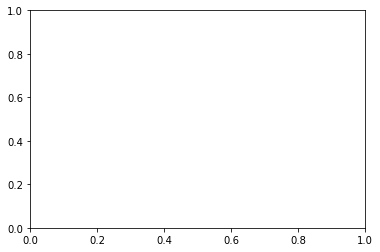

In [69]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title('$C_l$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, train\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title('$C_d$ prediction, test\n1 CNN layers, 100 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
airfoiltest1_predict = decoded_test[16*0:16*1]

airfoiltest1_cl=y_test[16*0:16*1,0,:]
airfoiltest1_cd=y_test[16*0:16*1,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[0*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
airfoiltest37_predict = decoded_test[16*1:16*2]

airfoiltest37_cl=y_test[16*1:16*2,0,:]
airfoiltest37_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'r', marker='o',lw=1)
plt.plot(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 2 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)\n1 CNN layer, 100 kernels', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

In [ ]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)\n1 CNN layer, 100 kernels', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

In [ ]:
airfoiltest3_predict = decoded_test[16*2:16*3]

airfoiltest3_cl=y_test[16*2:16*3,0,:]
airfoiltest3_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest3_predict[:,0,:] - airfoiltest3_cl)**2) / np.sum(airfoiltest3_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest3_predict[:,1,:] - airfoiltest3_cd)**2) / np.sum(airfoiltest3_cd**2))

plt.plot(alpha, airfoiltest3_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,0,:].reshape(16,), marker='s', c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest3_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,1,:].reshape(16,), marker='s',c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
airfoiltest11_predict = decoded_test[16*5:16*6]

airfoiltest11_cl=y_test[16*5:16*6,0,:]
airfoiltest11_cd=y_test[16*5:16*6,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))

plt.plot(alpha, airfoiltest11_cl.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest11_cd.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 6 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[5*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()